In [ ]:
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.decomposition import PCA
from pymutspec.draw import plot_mutspec12

from utils import get_equilibrium_freqs_rnd, transitions, prepare_exp_aa_subst

# from psynlig import pca_2d_scores

my_palette = sns.diverging_palette(12, 255, s=100, sep=50, as_cmap=True)

matplotlib.colormaps.register(my_palette, name="RedBlue3")

## Random spectra consequenses

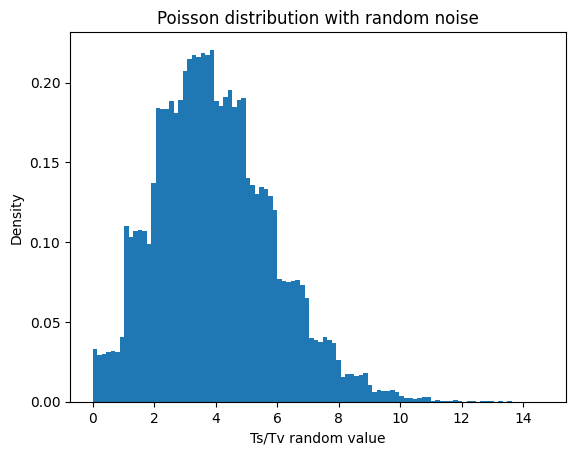

In [2]:
tstv_ratios = np.random.poisson(3.5, 100000) + np.random.random(100000)
plt.hist(tstv_ratios, 100, density=True)
plt.title('Poisson distribution with random noise')
plt.xlabel('Ts/Tv random value')
plt.ylabel('Density')
plt.show()

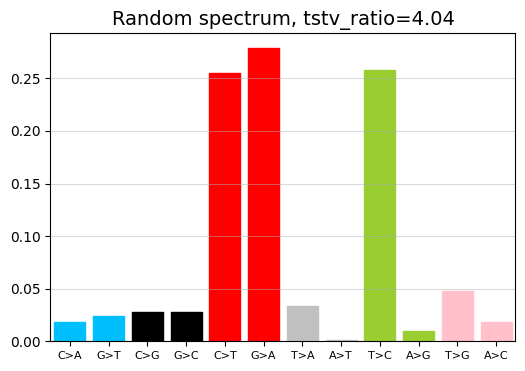

<Axes: title={'center': 'Random spectrum, tstv_ratio=4.04'}>

In [12]:
i = 102
rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=tstv_ratios[i])
plot_mutspec12(rnd_sp, title=f'Random spectrum, tstv_ratio={tstv_ratios[i]:.2f}')

In [13]:
from warnings import filterwarnings
filterwarnings("ignore",)

In [14]:
def get_looser_gainer_score(exp_aa_subst_matrix):
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    flow = _freqs_to - _freqs_from
    return flow

In [56]:
nsamples = 1000
tstv_ratios = np.random.poisson(3.5, nsamples) + np.random.random(nsamples)

random_eq_freqs = []
random_ms = []
looser_gainer_score = []
for replic, x in enumerate(tstv_ratios, 1):
    cur_tstv_ratio = round(x, 1)
    # cur_tstv_ratio = None
    rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=cur_tstv_ratio)
    rnd_sp = rnd_sp.assign(tstv_ratio=cur_tstv_ratio, replic=replic)

    _, exp_aa_subst_matrix = prepare_exp_aa_subst(rnd_sp, 'MutSpec')
    cur_looser_gainer_score = get_looser_gainer_score(exp_aa_subst_matrix)\
        .rename('flow_score').reset_index().assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    looser_gainer_score.append(cur_looser_gainer_score)
    
    rnd_eq_aa_freqs = rnd_eq_aa_freqs.assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    # one_sample = pd.concat([
    #     rnd_sp.pivot(index='tstv_ratio', columns='Mut', values='MutSpec'),
    #     rnd_eq_aa_freqs.pivot(index='tstv_ratio', columns='aa', values='eq_freq')
    # ], axis=1)
    random_eq_freqs.append(rnd_eq_aa_freqs)
    random_ms.append(rnd_sp)

random_eq_freqs = pd.concat(random_eq_freqs, ignore_index=False)
random_ms = pd.concat(random_ms, ignore_index=False)
looser_gainer_score = pd.concat(looser_gainer_score, ignore_index=False)

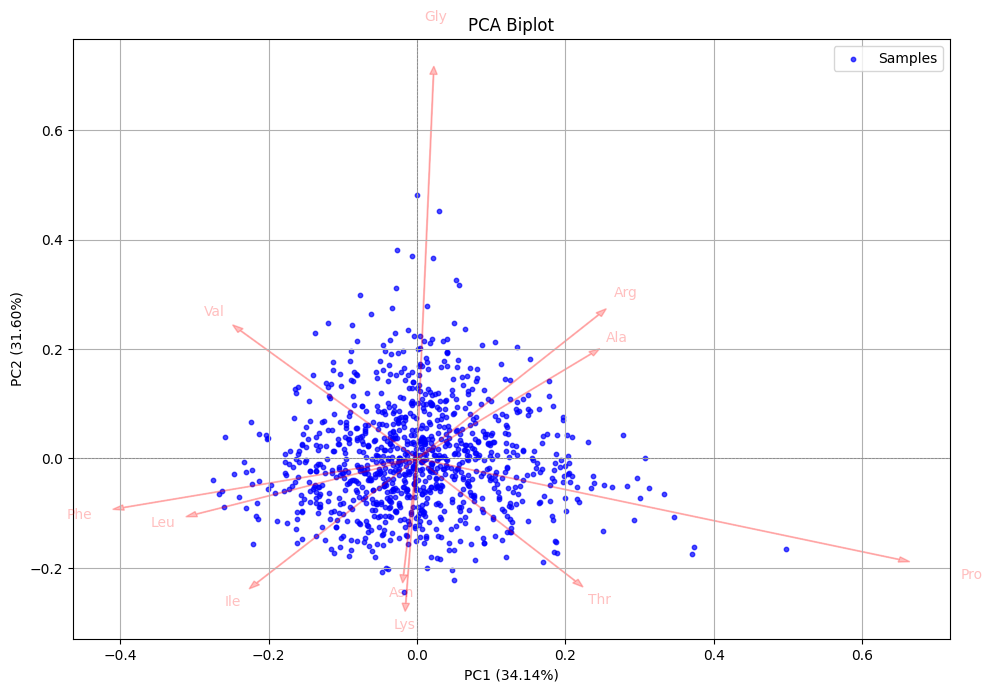

In [57]:
X = random_eq_freqs.pivot(index=['replic'], columns='aa', values='eq_freq').fillna(0)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a biplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, label='Samples', s=10, c='blue')

# Add feature vectors (show only the most valuable ones)
threshold = 0.2  # Adjust this threshold to filter vectors
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    magnitude = np.sqrt(comp1**2 + comp2**2)
    if magnitude > threshold:
        plt.arrow(0, 0, comp1 , comp2 , color='red', alpha=0.25, head_width=0.01)
        plt.text(comp1 * 1.15, comp2 * 1.15, X.columns[i], alpha=0.25, color='red', ha='center', va='center')

# Update axis labels with explained variance
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [54]:
from multiprocessing import Pool

def process_tstv_ratio(x_replic):
    x, replic = x_replic
    cur_tstv_ratio = round(x, 1)
    rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=cur_tstv_ratio)
    rnd_sp = rnd_sp.assign(tstv_ratio=cur_tstv_ratio, replic=replic)

    _, exp_aa_subst_matrix = prepare_exp_aa_subst(rnd_sp, 'MutSpec')
    cur_looser_gainer_score = get_looser_gainer_score(exp_aa_subst_matrix)\
        .rename('flow_score').reset_index().assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    
    rnd_eq_aa_freqs = rnd_eq_aa_freqs.assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    return rnd_eq_aa_freqs, rnd_sp, cur_looser_gainer_score

nsamples = 1000
tstv_ratios = np.random.poisson(3.5, nsamples) + np.random.random(nsamples)

# Prepare data for parallel processing
data = [(x, replic) for replic, x in enumerate(tstv_ratios, 1)]

# Use multiprocessing Pool
with Pool(processes=6) as pool:
    results = pool.map(process_tstv_ratio, data)

# Collect results
random_eq_freqs, random_ms, looser_gainer_score = zip(*results)
random_eq_freqs = pd.concat(random_eq_freqs, ignore_index=False)
random_ms = pd.concat(random_ms, ignore_index=False)
looser_gainer_score = pd.concat(looser_gainer_score, ignore_index=False)

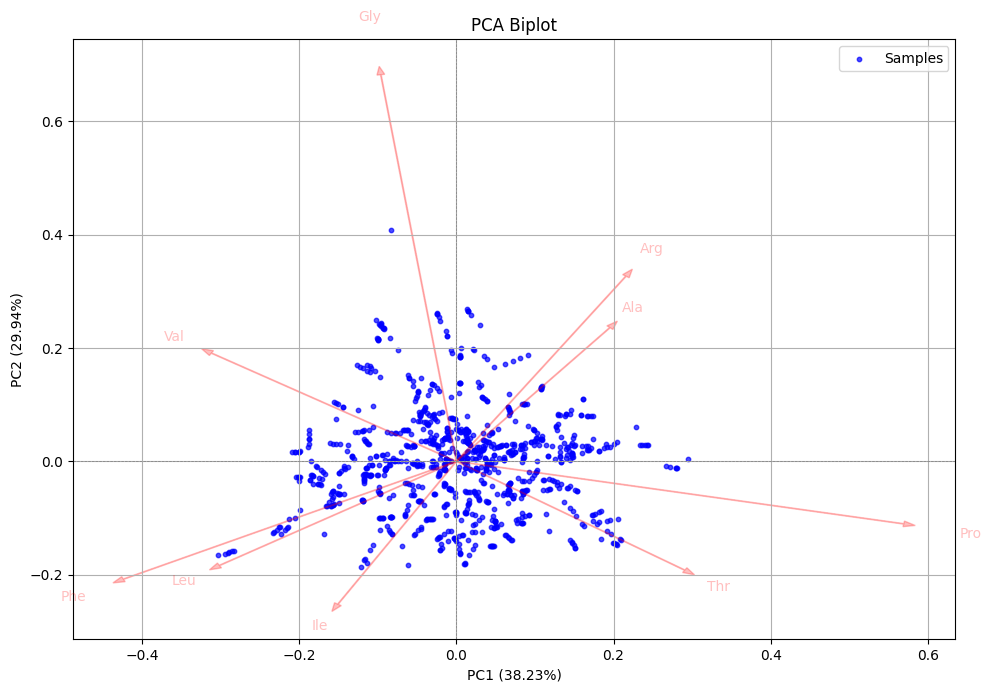

In [55]:
X = random_eq_freqs.pivot(index=['replic'], columns='aa', values='eq_freq').fillna(0)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a biplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, label='Samples', s=10, c='blue')

# Add feature vectors (show only the most valuable ones)
threshold = 0.2  # Adjust this threshold to filter vectors
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    magnitude = np.sqrt(comp1**2 + comp2**2)
    if magnitude > threshold:
        plt.arrow(0, 0, comp1 , comp2 , color='red', alpha=0.25, head_width=0.01)
        plt.text(comp1 * 1.15, comp2 * 1.15, X.columns[i], alpha=0.25, color='red', ha='center', va='center')

# Update axis labels with explained variance
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.title('PCA Biplot')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [21]:
random_ms#.tstv_ratio.describe()

,Mut,MutSpec,tstv_ratio,replic
0,A>C,0.009881,4.3,1
1,A>G,0.273231,4.3,1
2,A>T,0.042284,4.3,1
3,C>A,0.039147,4.3,1
4,C>G,0.034427,4.3,1
...,...,...,...,...
7,G>C,0.000388,1.7,10
8,G>T,0.076776,1.7,10
9,T>A,0.027560,1.7,10
10,T>C,0.010319,1.7,10


Text(0.5, 1.0, 'Loser-Gainer score distribution on random spectra')

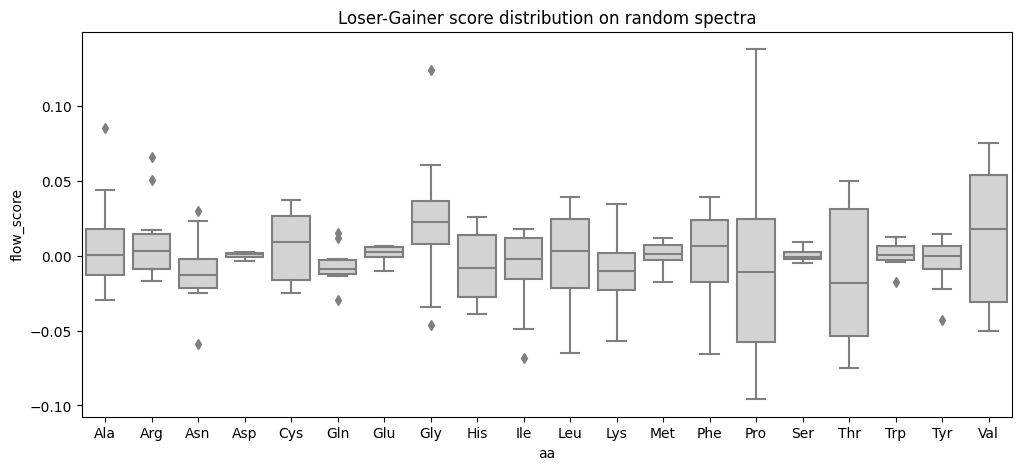

In [22]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(
    looser_gainer_score, 
    # order=looser_gainer_score.groupby('aa').flow_score.mean().sort_values(ascending=False).index,
    x='aa', y='flow_score', 
    color='lightgray',
    # palette='RedBlue3', 
#     edgecolor=".65"
)
ax.set_title('Loser-Gainer score distribution on random spectra')

<Axes: xlabel='aa', ylabel='eq_freq'>

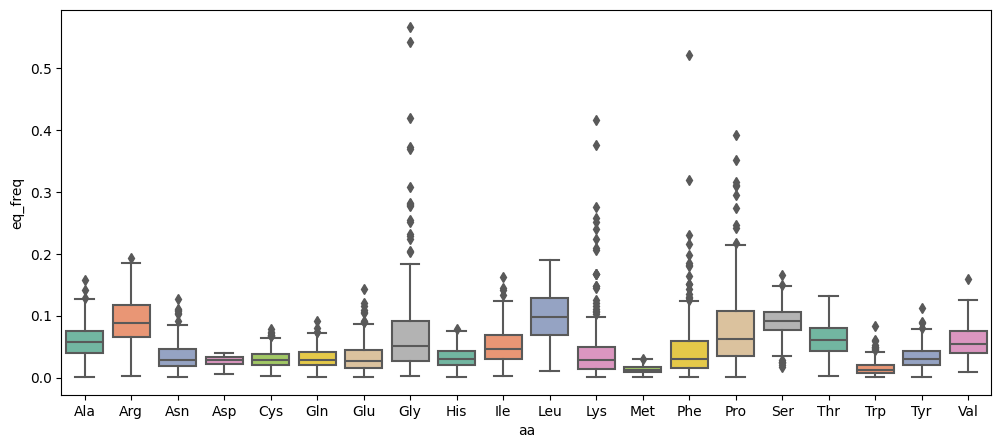

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(random_eq_freqs, x='aa', y='eq_freq',
            palette='Set2', order=sorted(random_eq_freqs.aa.unique()))

<Axes: xlabel='Mut', ylabel='MutSpec'>

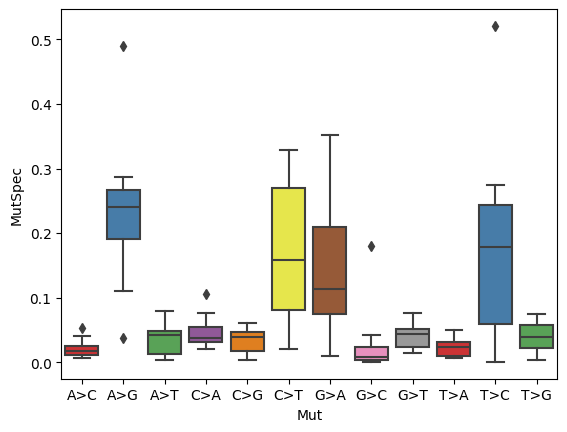

In [23]:
sns.boxplot(random_ms, x='Mut', y='MutSpec',
            palette='Set1', )

## Load RdRp amino acid freqs

In [ ]:
'../../Sars_Cov_2_MutSpec/Sars_Cov_2/data/Covid_ref.fasta'

In [ ]:
serratus_data = pd.read_csv('../data/FullData.txt', sep='\t')